The goal of this project is to use machine learning to create a model using deep learning that can suggests tags for a question on [MathOverflow](https://mathoverflow.net) from the title. This is an example of a multiclass multilabel classification problem. This notebook was created using [Google Colab](https://colab.research.google.com/?utm_source=scs-index) and the model is constructed using Keras in TensorFlow.

MathOverflow is a research-level Q&A site for mathematicians. Each question must have between 1 and 5 tags. The tags serve to organize the questions by area of math.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
#allow importing of data from google drive
from google.colab import drive  
drive.mount('/content/drive')

We start by importing and merging all our data and labels. Our data was manually queried using SQL from Stack Exchange Data Explorer, https://data.stackexchange.com/. It consists of 3 subsets of data, organized by date, on questions asked between 2018 and early 2022, for a total of 47206 entries. I originally gathered more data but ended up restricting to this due to resource constraints in Colab.


In [71]:
import glob
import os

#import dataset with tags info
path_tags = '/content/drive/MyDrive/data/tags.csv'
tags = pd.read_csv(path_tags)

#create and merge csv files into dataframe
base_data_path = '/content/drive/MyDrive/data'
data_files = os.path.join(base_data_path, '2*.csv')
data_files = glob.glob(data_files)
df = pd.concat(map(pd.read_csv, data_files), ignore_index=True)
print('Number of questions:', len(df))

Number of questions: 47206


To prepare our data we tokenize the titles and use a one-hot encoding. We restrict our dictionary to the 10000 most common words.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

#instantiate the tokenizer and set the max dictionary size
max_num_words = 10000
tokenizer = Tokenizer(num_words = max_num_words)
#build word index
tokenizer.fit_on_texts(df['Title'])
#check size of dictionary
word_index = tokenizer.word_index
print('Number of unique words:', len(word_index))

#turn strings into integer indeces
#why?
sequences = tokenizer.texts_to_sequences(df['Title'])

#get one-hot binary representation
one_hot_results = tokenizer.texts_to_matrix(df['Title'], mode='binary')

Number of unique words: 16182


We do the same for our labels, restricting to the 1000 most commonly used tags (the total number of tags used during this time period is given as output of the following cell). For interest, the 500 least used tags have been used (approximately) less than 20 times each, all-time.

In [ ]:
#instantiate the tag tokenizer and set the max dictionary size
#NOTE: There are 1520 tags so this doesn't include them them all.
#NOTE: Tags are listed like <tag-1>...<tag-k>, where k <= 5, so we only need to filter out the chars <>
max_num_tags = 1000
tag_tokenizer = Tokenizer(num_words = max_num_tags, filters='<>')
#build word index
tag_tokenizer.fit_on_texts(df['Tags'])
#check size of dictionary
tag_index = tag_tokenizer.word_index
print('Number of unique tags:', len(tag_index))

#turn strings into integer indeces
#why?
tag_sequences = tag_tokenizer.texts_to_sequences(df['Tags'])

#get one-hot binary representation
tag_one_hot_results = tag_tokenizer.texts_to_matrix(df['Tags'], mode='binary')

Number of unique tags: 1473


Before we do anything else let's take a look at our data to get a better feeling of what we're dealing with and double check it makes sense. The following code block tells us the average length per title, plot a histogram of title lengths, and plot the frequency distribution of the 20 most commonly used words.

Average number of words per title: 8.0


Text(0.5, 1.0, 'Sample length distribution')

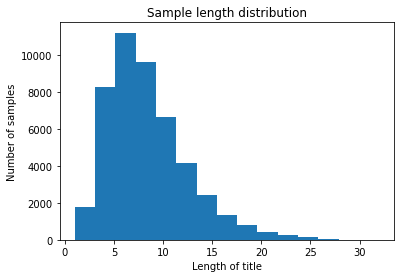

In [ ]:
import matplotlib.pyplot as plt

num_words = [len(title.split()) for title in df['Title']]
avg_num_words = np.median(num_words)
print('Average number of words per title:', avg_num_words)

plt.hist(num_words, 15)
plt.xlabel('Length of title')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')

Text(0.5, 1.0, 'Frequency distribution of the 20 most common words')

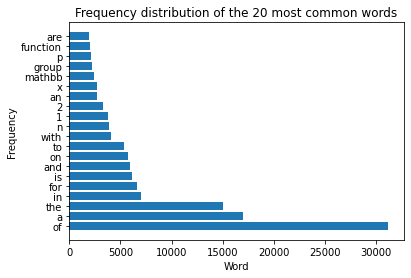

In [ ]:
plt.clf()
#get a list of (word, frequency) pairs sorted in decreasing order by frequency from the tokenizer
common_words = sorted(tokenizer.word_counts.items(), key = lambda x: x[1], reverse=True)
num_most_common = 20
x_data = [common_words[i][0] for i in range(num_most_common)]
y_data = [common_words[i][1] for i in range(num_most_common)]
plt.barh(x_data, y_data)
plt.xlabel('Word'), plt.ylabel('Frequency')
plt.title('Frequency distribution of the '+str(num_most_common)+' most common words')

Next, we shuffle and split our data and labels into training, validation, and test parts. Since we have a wealth of data, a hold-out validation set should be a sufficient evaluation protocol. The number of samples of each type are as follows:

*   training = 30000 (of which 10000 are reserved for validation)
*   testing = 17206
*   total = 47206



In [ ]:
training_size = 30000
val_size = 10000

#rename and shuffle
data, labels = one_hot_results, tag_one_hot_results
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data, labels = data[indices], labels[indices]

train_data, test_data = data[:training_size], data[training_size:]
train_labels, test_labels = labels[:training_size], labels[training_size:]

#set aside validation data and labels, and rename training data and labels.
val_data, val_labels = train_data[:val_size], train_labels[:val_size]
train_data, train_labels = train_data[val_size:], train_labels[val_size:]

---
Now that we have our data in a nice form let's build the model. Since it's a multiclass multilabel problem our last layer should be sigmoid and a good loss function is binary_crossentropy. The number of units in the last layer should be the number of possible labels (tags). We give each layer 1028 hidden units since we want that number to be larger than the dimension of our output space (1000). I tried training the model with and without dropout to regularize it. I had no particular reason for choosing the number of layers or the optimizer.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

#create the model
hidden_units = 1028
model = models.Sequential()
model.add(layers.Dense(hidden_units, activation='relu', input_shape=(10000,)))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(hidden_units, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(max_num_tags, activation='sigmoid'))

#compile it
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#train the model
history = model.fit(train_data, train_labels,
                    epochs=9, batch_size=512,
                    validation_data=(val_data, val_labels))

In [ ]:
#alternatively we can load one of our pretrained models
#model = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/mo_tag_suggestions2_no_dropout')
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/mo_tag_suggestions2_w_dropout')
#model.summary()

To evaluate our model and avoid overfitting, we plot the training and validation loss and accuracy.

In [ ]:
import matplotlib.pyplot as plt

#get dictionary of data history of the model and extract relevant stuff to plot
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss)+1)

In [ ]:
#Plot training and validation loss
#if necessary, you can change the offset skip the first few data points to get a nicer graph
offset, val_offset = 1, 1
plt.plot(range(1 + offset, len(epochs)+1), loss[offset:], 'bo', label='Training loss')
plt.plot(range(1 + val_offset, len(epochs)+1), val_loss[val_offset:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Plot training and validation accuracy
plt.clf()
offset, val_offset = 0, 0
plt.plot(range(1 + offset, len(epochs)+1), acc[offset:], 'bo', label='Training accuracy')
plt.plot(range(1 + val_offset, len(epochs)+1), val_acc[val_offset:], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

I tried fitting the model for 25/20 epochs with/without dropout. The results are shown below.

With two layers of dropout:
1. 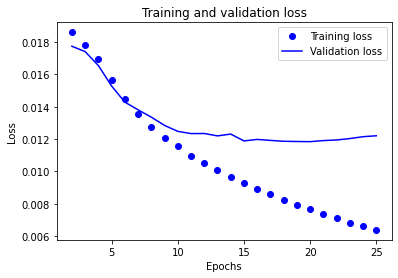
2. 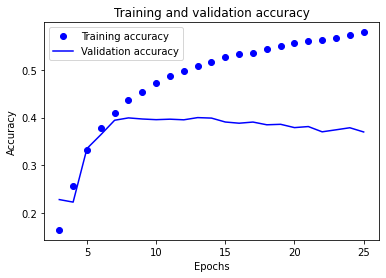

With no dropout:
1. 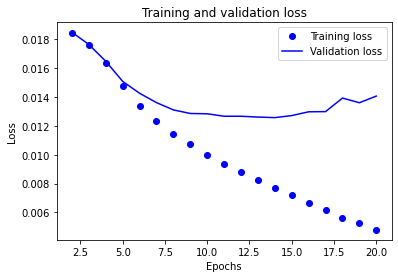
2. 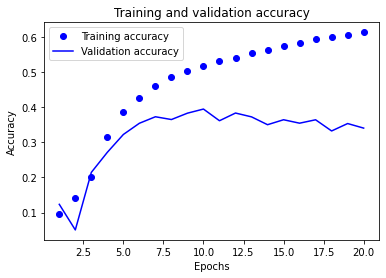

Using these graphs we can see when the model starts to overfit, then retrain and save an optimized version. Our no-dropout model is trained to 9 epochs and our dropout model is trained to 11. The latter is the model we will use for our examples below.

In [ ]:
#go back and retrain the model
#save the model to google drive
model.save('/content/drive/MyDrive/saved_models/mo_tag_suggestions2_no_dropout')

Finally, we give some examples of the model on test data. As we can see from running the next cell, the model has a 45% accuracy on our test data, which seems really good, or at least way above random!

In [ ]:
loss, acc = model.evaluate(test_data, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

538/538 - 14s - loss: 0.0112 - accuracy: 0.4542 - 14s/epoch - 26ms/step
Restored model, accuracy: 45.42%


Since there is no objectively *correct* set of tags for any MO question, let's test our model on some of our test questions and examine what we get. We start by writing some helper functions to show our predictions.

In [ ]:
#create bijection between tag strings and their values in our tokenizer
def get_tag_index(tag_name):
  return tag_index[tag_name]

inverse_tag_index = {}
for key, val in tag_index.items():
  inverse_tag_index[val] = key

def get_tag_name(tag_index):
  return inverse_tag_index[tag_index]

In [ ]:
#create a function to guess the tags of a post from it's title (given an array containing the model's guess)

#first we need to be able to fin  d the n largest elements from a numpy array and their indices
#the following fn returns a dictionary of n items
#each key is one of the n largest items in the array
#each value is the position in the array of that value
def maxn_dict(array, n=1):
  result = {}
  ar = np.copy(array)
  ind = np.argpartition(ar, -n)[-n:]
  for i in range(len(ind)):
    result[ar[ind][i]] = ind[i]
  return result

def guess_tags(array, n=5):
  tags_w_probability = maxn_dict(array, n)
  for k, v in tags_w_probability.items():
    tags_w_probability[k] = get_tag_name(v)
  return tags_w_probability

#print_predicted_tags takes a prediction from the model and prints the names and prediction probability
#of the n most likely tags, having probability at least (threshold*100)%
def print_predicted_tags(array, n=5, threshold=0):
  high_prob_tags = guess_tags(array, n)
  for k, v in high_prob_tags.items():
    if k > threshold:
      print(v, str(int(k*100))+'%')

def check_true_tags(array):
  result = np.where(array==1)
  true_tags=[]
  for r in result[0]:
    true_tags.append(get_tag_name(r))
  return true_tags

def guess_and_check(array, list):
  for n in list:
    print('\nTest sample ' + str(n))
    print('\nWe suggest the following tags:')
    print_predicted_tags(array[n], n=5, threshold=0.02)
    print('\nTrue tags used: ' + str(check_true_tags(test_labels[n])))

In [ ]:
#show predicted and given tags for the first n questions in our test set
n=100
predictions = model.predict(test_data[:n])
guess_and_check(predictions, range(n))

As we can see from the results (see relevant text files), the model does a pretty good job at suggesting tags! It frequently suggests the same tags that were put on the question, and the other tags it suggests are generally within the same realm of math. For example, on test sample 0 with true tags ['reductive-groups', 'galois-representations', 'langlands-conjectures'], the top 10 tags it suggests are (not in order) finite-groups, langlands-conjectures, reference-request, gr.group-theory, automorphic-forms, reductive-groups, algebraic-number-theory, nt.number-theory, modular-forms, rt.representation-theory, reference-request, automorphic-forms, gr.group-theory, algebraic-number-theory, nt.number-theory, modular-forms, and rt.representation-theory. We can see the model has learned some math.

For some fun and further validation we can test the model on titles we come up with! I do this with a few titles below. Feel free to add more and try it yourself!

In [ ]:
#test on some titles I made up
titles = ['Proof that the Hodge bundle $\omega$ is an invertible sheaf on the modular curve.', 'A good reference for algebraic stacks.']
my_titles = tokenizer.texts_to_matrix(titles, mode='binary')
my_pred = model.predict(my_titles)
for i in range(len(titles)):
  print('\nTitle:', titles[i])
  print('\nPredicted tags:')
  print_predicted_tags(my_pred[i], n=5, threshold=0)


Title: Proof that the Hodge bundle $\omega$ is an invertible sheaf on the modular curve.

Predicted tags:
hodge-theory 9%
moduli-spaces 9%
dg.differential-geometry 13%
complex-geometry 34%
ag.algebraic-geometry 93%

Title: A good reference for algebraic stacks.

Predicted tags:
homological-algebra 11%
sheaf-theory 12%
ct.category-theory 26%
reference-request 56%
ag.algebraic-geometry 81%
